In [ ]:
pip install pandas matplotlib tensorflow

In [4]:
import pandas as pd
data = pd.read_csv("/kaggle/input/tweets-csv/Tweets.csv")

In [5]:
review_data = data[['text','airline_sentiment']]
print(review_data.shape)
review_data.head(10)

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive
7,@VirginAmerica Really missed a prime opportuni...,neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an ...",positive


In [6]:
review_data = review_data[review_data['airline_sentiment'] != 'neutral']
print(review_data.shape)
review_data.head(5)

(11541, 2)


,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [7]:
review_data["airline_sentiment"].value_counts()

airline_sentiment
negative    9178
positive    2363
Name: count, dtype: int64

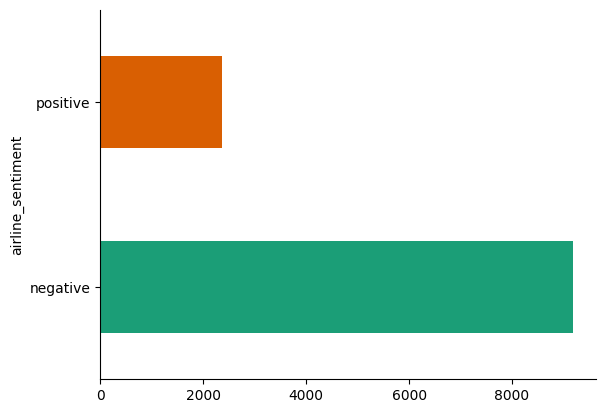

In [8]:
# @title airline_sentiment

from matplotlib import pyplot as plt
import seaborn as sns
review_data.groupby('airline_sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
sentiment_label = review_data.airline_sentiment.factorize()  #0 represents positive sentiment and the 1 represents negative sentiment.
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

In [10]:
tweet = review_data.text.values

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=50000)

tokenizer.fit_on_texts(tweet)

2024-07-07 19:44:57.695447: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 19:44:57.695601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 19:44:57.832314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
encoded_docs = tokenizer.texts_to_sequences(tweet)

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padsequence = pad_sequences(encoded_docs, maxlen=200)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
embedding_vector_length = 32
vocab_size=13250
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           424000    
                                                                 
 spatial_dropout1d (Spatial  (None, 200, 32)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 440651 (1.68 MB)
Trainable params: 440651 (1.68 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [15]:
history = model.fit(padsequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5


I0000 00:00:1720382000.832932     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


289/289 [==============================] - 182s 608ms/step - loss: 0.3924 - accuracy: 0.8355 - val_loss: 0.2138 - val_accuracy: 0.9134
Epoch 2/5
289/289 [==============================] - 164s 568ms/step - loss: 0.2080 - accuracy: 0.9218 - val_loss: 0.1680 - val_accuracy: 0.9407
Epoch 3/5
289/289 [==============================] - 161s 557ms/step - loss: 0.1560 - accuracy: 0.9425 - val_loss: 0.1721 - val_accuracy: 0.9376
Epoch 4/5
289/289 [==============================] - 164s 566ms/step - loss: 0.1072 - accuracy: 0.9632 - val_loss: 0.1894 - val_accuracy: 0.9363
Epoch 5/5
289/289 [==============================] - 161s 557ms/step - loss: 0.0867 - accuracy: 0.9697 - val_loss: 0.2076 - val_accuracy: 0.9424


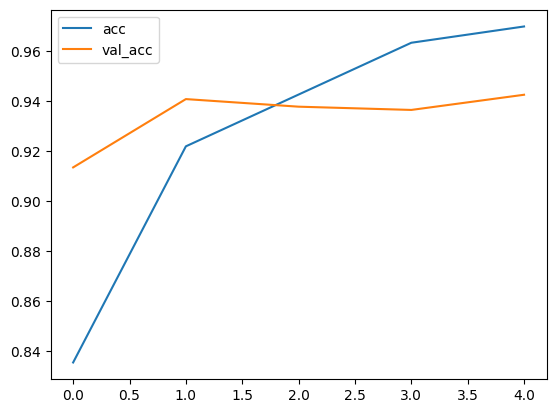

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.savefig("Accuracy plot.jpg")

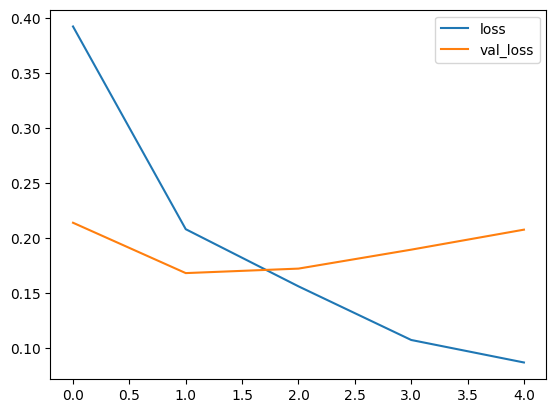

<Figure size 640x480 with 0 Axes>

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

plt.savefig("Loss plt.jpg")

In [18]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

In [21]:
test_sentence1 = input("Enter the FIRST sentence to TEST: ")
predict_sentiment(test_sentence1)

Enter the FIRST sentence to TEST:  Limited success in market outreach


1/1 [==============================] - 0s 72ms/step
Predicted label:  negative


In [22]:
test_sentence2 =input("Enter the SECOND sentence to TEST:")
predict_sentiment(test_sentence2)

Enter the SECOND sentence to TEST: Achieved market penetration goals.


1/1 [==============================] - 0s 69ms/step
Predicted label:  positive
